### IR Measurement



In [1]:
import pyfar as pf
import sounddevice as sd
import numpy as np
import matplotlib.pyplot as plt
import os
import sofar as sf
import time

In [4]:
2**16 / 48e3

1.3653333333333333

### Generate Excitation Signal

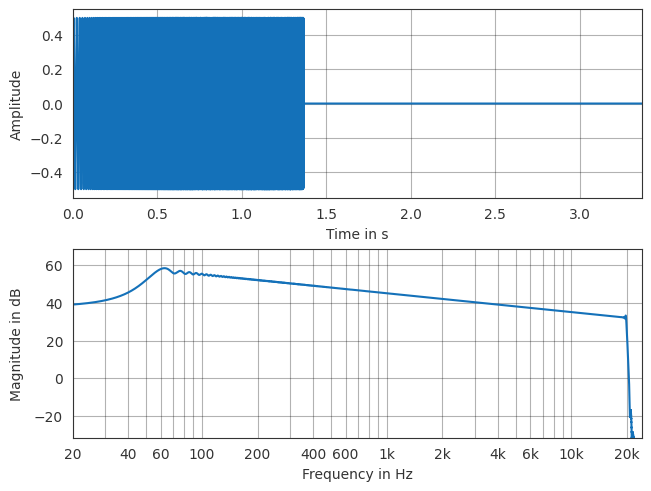

In [2]:
fs = 48e3
sweep = pf.signals.exponential_sweep_time(2**16, sampling_rate=fs, 
                                          amplitude=0.5,
                                          frequency_range=(50, 20e3))

# add one second of silence at the end
sweep = pf.dsp.pad_zeros(sweep, int(fs*2))

pf.plot.time_freq(sweep)
plt.show()


### Initialize Device

In [3]:
devices = sd.query_devices()
print(devices)

# Set device by entering D & samplerate
sd.default.device = 22
sd.default.samplerate = fs


   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Analog (5+6) (2- RME Fireface U, MME (2 in, 0 out)
   2 Analog (1+2) (2- RME Fireface U, MME (2 in, 0 out)
   3 Mikrofon (Realtek High Definiti, MME (2 in, 0 out)
   4 Analog (3+4) (2- RME Fireface U, MME (2 in, 0 out)
   5 Stereomix (Realtek High Definit, MME (2 in, 0 out)
   6 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  7 Speakers/Headphones (Realtek Hi, MME (0 in, 2 out)
   8 Analog (5+6) (2- RME Fireface U, MME (0 in, 2 out)
   9 Analog (3+4) (2- RME Fireface U, MME (0 in, 2 out)
  10 Lautsprecher (2- RME Fireface U, MME (0 in, 2 out)
  11 Primärer Soundaufnahmetreiber, Windows DirectSound (2 in, 0 out)
  12 Analog (5+6) (2- RME Fireface UFX), Windows DirectSound (2 in, 0 out)
  13 Analog (1+2) (2- RME Fireface UFX), Windows DirectSound (2 in, 0 out)
  14 Mikrofon (Realtek High Definition Audio), Windows DirectSound (2 in, 0 out)
  15 Analog (3+4) (2- RME Fireface UFX), Windows DirectSound (2 in, 0 out)
  16 Ster

### Device Response

In [9]:
for i in range(10):
    sd.play(sweep.time.T, sweep.sampling_rate, mapping=[1], blocking=True)

In [18]:
preamp_fireface = np.zeros((5, sweep.n_samples))

for i in range(5):
    rec = sd.playrec(sweep.time.T, samplerate=fs,
                         input_mapping=[15], 
                         output_mapping=[1], 
                         blocking=True).T
    
    preamp_fireface[i] = rec

In [17]:
preamp_fireface.shape

(5, 161536)

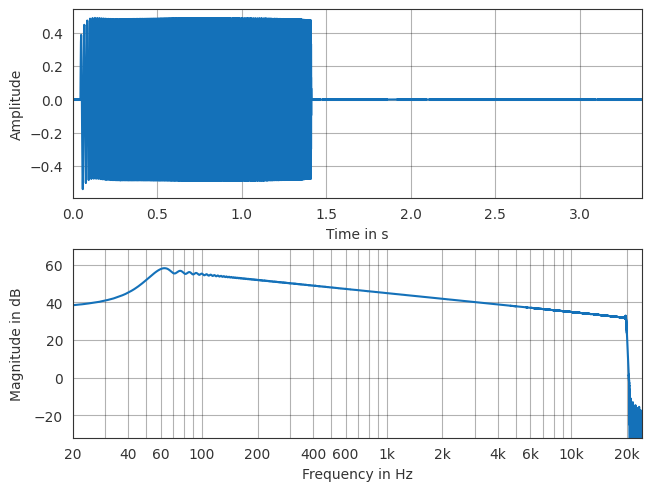

In [23]:
sig_ = pf.Signal(preamp_fireface, fs)
sig_ = pf.dsp.average(sig_, caxis=0)

pf.plot.time_freq(sig_)
plt.show()
pf.io.write_audio(sig_, r'BRIR_Window_Room/system_response_preamp_channel_fireface.wav')

In [30]:
0.045 * fs

2160.0

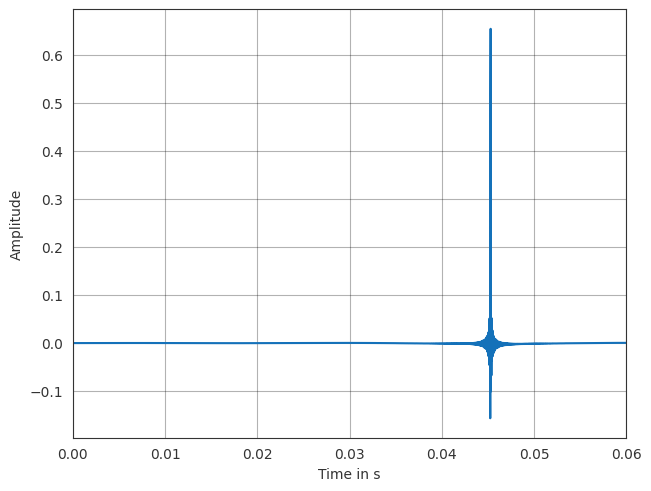

In [29]:
pf.plot.time(pf.dsp.deconvolve(sig_, sweep, freq_range=(50, 19500)))
plt.xlim(0, 0.06)
plt.show()

### Reference Recording

<p>Connect output of the measuring device to input to capture system response
for compensation.</p>

In [ ]:
# ADAT begins at channel 15, mapping starts at id=1
reference = sd.playrec(sweep.time.T, channels=1, samplerate=fs,
                         input_mapping=[15], 
                         output_mapping=[1], 
                         blocking=True)

ref = pf.Signal(reference.squeeze(), fs)

# save reference signal as wav file
fp = r"Measurements/reference.wav"
pf.io.write_audio(ref, fp, overwrite=False)

### Recording with turntable

In [4]:
# define azimuth angles
step = 2.5
azimuth = np.arange(-45, 46, step=step)

system_response = np.zeros((len(azimuth), 2, sweep.n_samples))

for i, az in enumerate(azimuth):
    print(f"Measuring at azimuth {az} deg")
    
    for _n in range(3):
        rec = sd.playrec(sweep.time.T, channels=2, samplerate=fs,
                        input_mapping=[13, 14],
                        output_mapping=[1], blocking=True)
        
        system_response[i] += rec.T
    
    system_response[i] /= 3

    input(f"Press 'Enter' to continue.\nNext measurement at {az+step}"
          " degree azimuth.")

Measuring at azimuth -45.0 deg
Measuring at azimuth -42.5 deg
Measuring at azimuth -40.0 deg
Measuring at azimuth -37.5 deg
Measuring at azimuth -35.0 deg
Measuring at azimuth -32.5 deg
Measuring at azimuth -30.0 deg
Measuring at azimuth -27.5 deg
Measuring at azimuth -25.0 deg
Measuring at azimuth -22.5 deg
Measuring at azimuth -20.0 deg
Measuring at azimuth -17.5 deg
Measuring at azimuth -15.0 deg
Measuring at azimuth -12.5 deg
Measuring at azimuth -10.0 deg
Measuring at azimuth -7.5 deg
Measuring at azimuth -5.0 deg
Measuring at azimuth -2.5 deg
Measuring at azimuth 0.0 deg
Measuring at azimuth 2.5 deg
Measuring at azimuth 5.0 deg
Measuring at azimuth 7.5 deg
Measuring at azimuth 10.0 deg
Measuring at azimuth 12.5 deg
Measuring at azimuth 15.0 deg
Measuring at azimuth 17.5 deg
Measuring at azimuth 20.0 deg
Measuring at azimuth 22.5 deg
Measuring at azimuth 25.0 deg
Measuring at azimuth 27.5 deg
Measuring at azimuth 30.0 deg
Measuring at azimuth 32.5 deg
Measuring at azimuth 35.0 deg

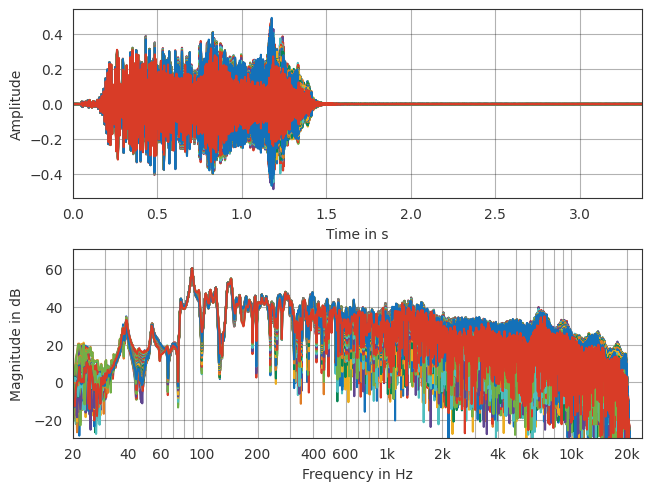

In [5]:
measurement = pf.Signal(system_response, fs)
pf.plot.time_freq(measurement)
plt.show()

In [74]:
measurement.time.shape[-1]

161536

In [75]:
data = measurement.time.reshape(-1, measurement.time.shape[-1])

In [77]:
reshaped = data.reshape(len(azimuth), 2, sweep.n_samples)

In [79]:
np.testing.assert_equal(reshaped, measurement.time)

In [ ]:
(32, 2, 51321)

(74, 51654461531)

In [56]:
np.save(r"BRIR_Window_Room/angle_2", azimuth)

In [7]:
pf.io.write_audio(measurement, r"BRIR_Window_Room/system_response_dummyhead_2.wav")

c:\Users\HP\anaconda3\envs\eds\lib\site-packages\pyfar\io\io.py:450: UserWarning: Signal flattened to 74 channels.
  warnings.warn(f"Signal flattened to {data.shape[0]} channels.")


In [37]:
brir = pf.dsp.deconvolve(measurement, sweep)
brir_win = pf.dsp.time_window(brir, [0.95, 1], unit='s', shape='right', crop='window')

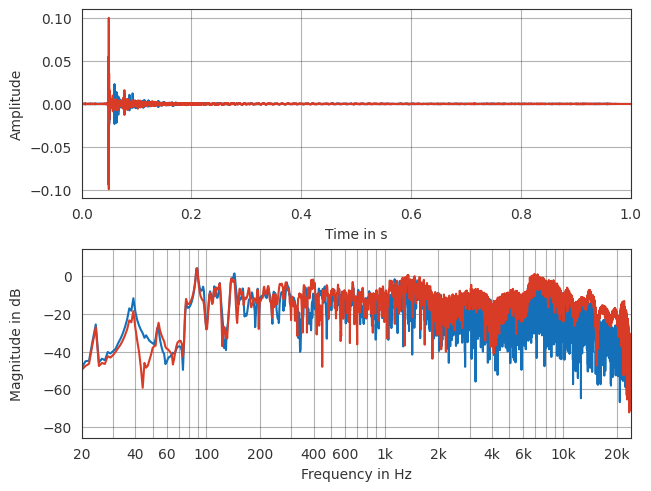

In [38]:
pf.plot.time_freq(brir_win[0])
plt.show()

In [ ]:
sofa = sf.Sofa('SingleRoomSRIR')

In [ ]:
# save data to SOFA file
azi = np.tile(azimuth, (16, 1))
azi = azi.flatten(order='F')

### RAR IR Measurment

In [65]:
ema_16_rar = np.zeros((3, 16, sweep.n_samples))

for i in range(3):
    rec = sd.playrec(sweep.time.T, samplerate=fs,
                         input_mapping=np.arange(15, 31), 
                         output_mapping=[1], 
                         blocking=True).T
    
    ema_16_rar[i] = rec

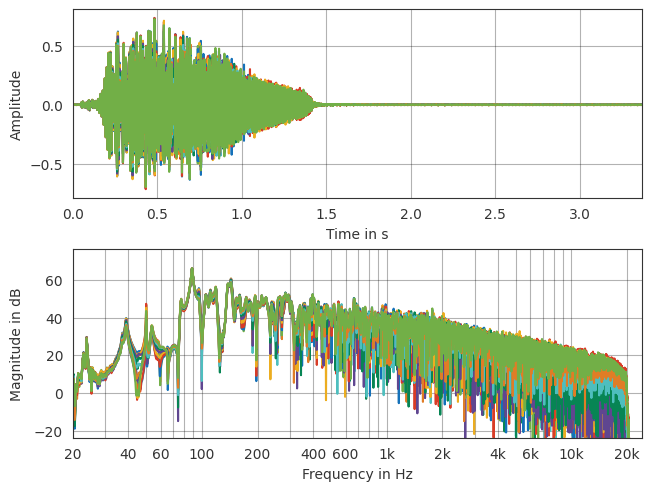

In [66]:
meas = pf.Signal(ema_16_rar, fs)
meas = pf.dsp.average(meas, caxis=0)

pf.plot.time_freq(meas, label='0')
plt.show()

In [67]:
pf.io.write_audio(meas, r"BRIR_Window_Room/ema_16.wav", overwrite=False)

### Reference RAR

In [53]:
ref_rar = np.zeros((5, sweep.n_samples))

for i in range(5):
    rec = sd.playrec(sweep.time.T, samplerate=fs,
                         input_mapping=[15], 
                         output_mapping=[1], 
                         blocking=True).T
    
    ref_rar[i] = rec

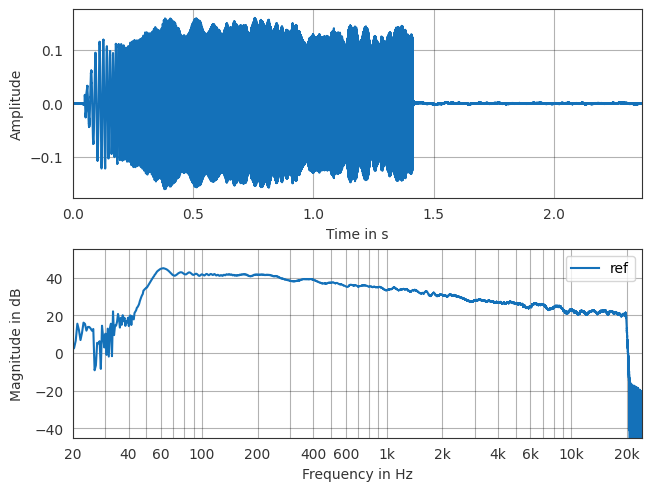

In [54]:
ref_rar_sig = pf.Signal(ref_rar, fs)
ref_rar_sig = pf.dsp.average(ref_rar_sig, caxis=0)

pf.plot.time_freq(ref_rar_sig, label='ref')
# pf.plot.time_freq(meas[0], label='ema')

plt.legend()
plt.show()  

In [55]:
pf.io.write_audio(ref_rar_sig, r"Measurements RAR/25_01_21_dummy_head_rar_50Hz_20kHz_reference.wav")

### Dummy head (clockwise rotation)

In [50]:
dummy_head = np.zeros((5, 2, sweep.n_samples))

for i in range(5):
    rec = sd.playrec(sweep.time.T, samplerate=fs,
                         input_mapping=[13, 14], 
                         output_mapping=[1], 
                         blocking=True).T
    
    dummy_head[i] = rec

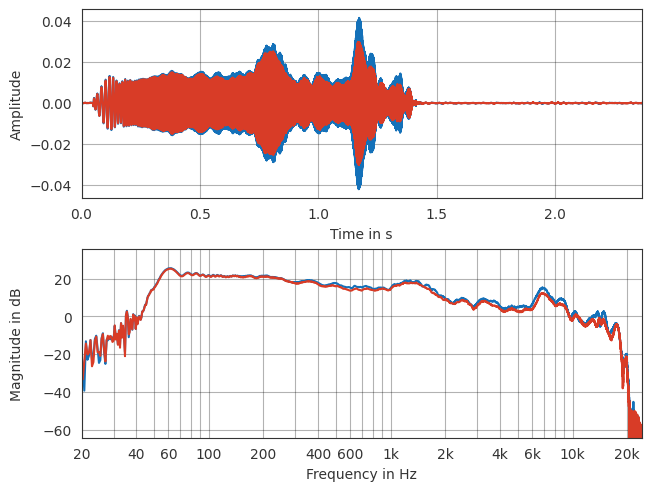

In [51]:
dummy_head_sig = pf.Signal(dummy_head, fs)
dummy_head_sig = pf.dsp.average(dummy_head_sig, caxis=0)

pf.plot.time_freq(dummy_head_sig, label='dummy_head')
plt.show()

In [52]:
pf.io.write_audio(dummy_head_sig, r"Measurements Rar/25_01_21_dummy_head_rar_50Hz_20kHz_180_degree.wav")

### Deconvolution

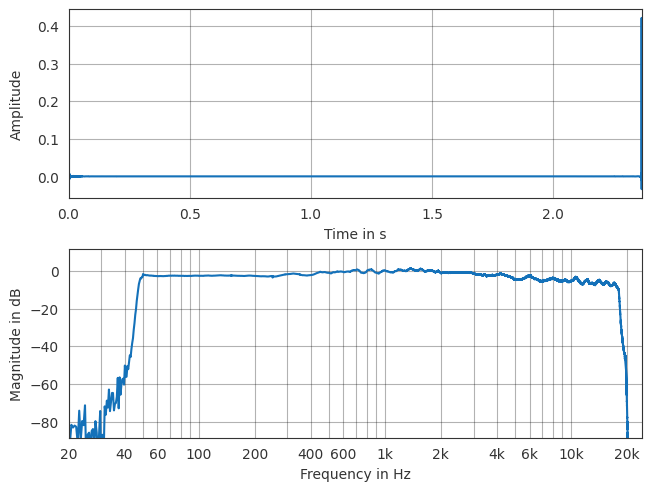

In [82]:
IR = pf.dsp.deconvolve(pf.dsp.normalize(meas)[0], pf.dsp.normalize(ref_rar_sig), freq_range=(50, 18e3))

pf.plot.time_freq(IR)
plt.show()

### Load Results

In [42]:
hrir_135 = pf.io.read_audio(r"Measurements RAR/25_01_21_dummy_head_rar_50Hz_20kHz_135_degree.wav")
hrir_90 = pf.io.read_audio(r"Measurements RAR/25_01_21_dummy_head_rar_50Hz_20kHz_90_degree.wav")

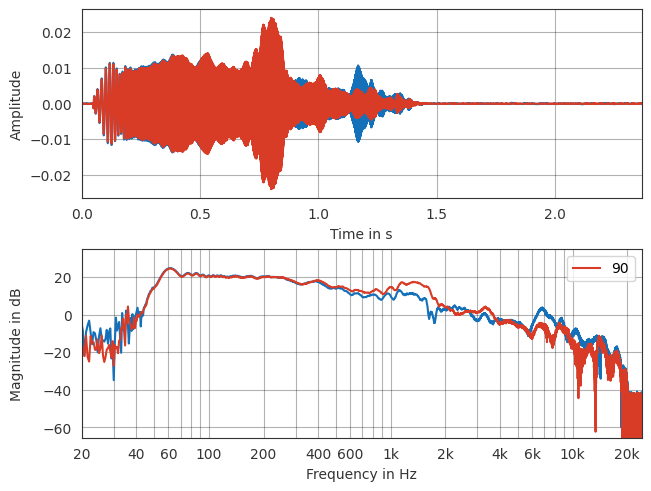

In [49]:
pf.plot.time_freq(hrir_135[1])
pf.plot.time_freq(hrir_90[1], label='90')
plt.legend()
plt.show()

### Recording of Anechoic Audio

<p> Listener Height: 1.20 <br>
Listener Distance: 1.45 <br>
Speaker Distance Within: 1.48 <br>
Speaker Height: 1.04

In [5]:
audio = pf.io.read_audio(r'signals/mov1_stereo.wav')
audio = pf.dsp.normalize(audio)

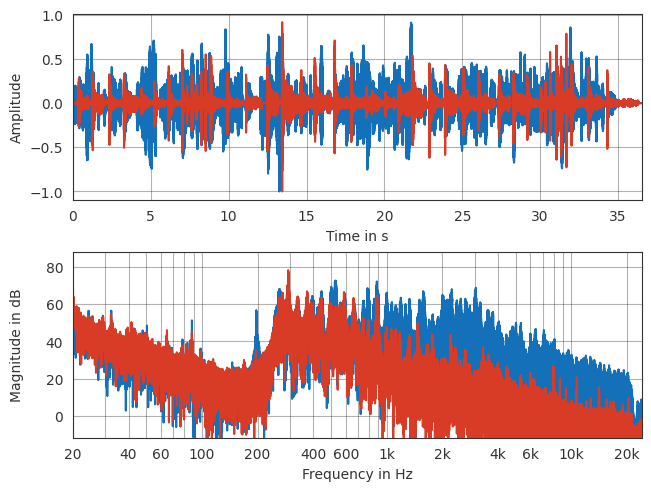

In [127]:
pf.plot.time_freq(audio)
plt.show()

In [6]:
ema_recording = sd.playrec(audio.time.T, input_mapping=np.arange(15, 31), output_mapping=[1, 2], blocking=True, samplerate=fs)

In [13]:
dummy_head = sd.playrec(audio.time.T, input_mapping=[13, 14], output_mapping=[1, 2], blocking=True, samplerate=fs)

In [14]:
dummy_head.shape

(1752868, 2)

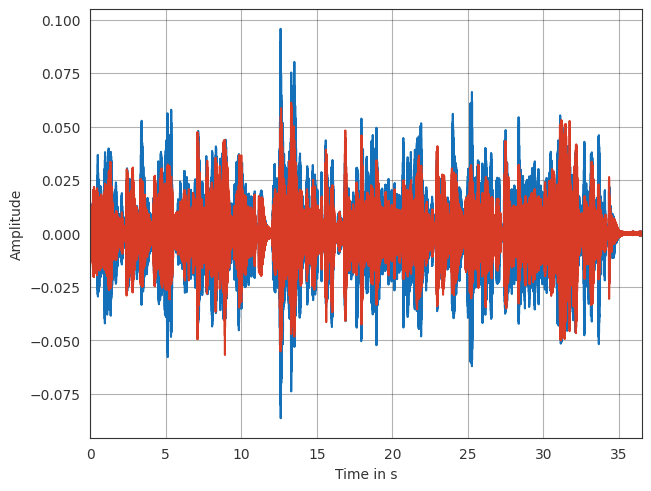

In [18]:
recording = pf.Signal(dummy_head.T, fs)
pf.io.write_audio(recording, r"Recording_Reverberant/dummy_head_2.wav")


pf.plot.time(recording)
plt.show()

In [110]:
test = sd.rec(int(48000*30), 48000, mapping=np.arange(15, 31), blocking=True)

In [111]:
sig = pf.Signal(test.T, 48000)
pf.io.write_audio(pf.dsp.normalize(sig, channel_handling='max'), r"Recording_Reverberant/test.wav")

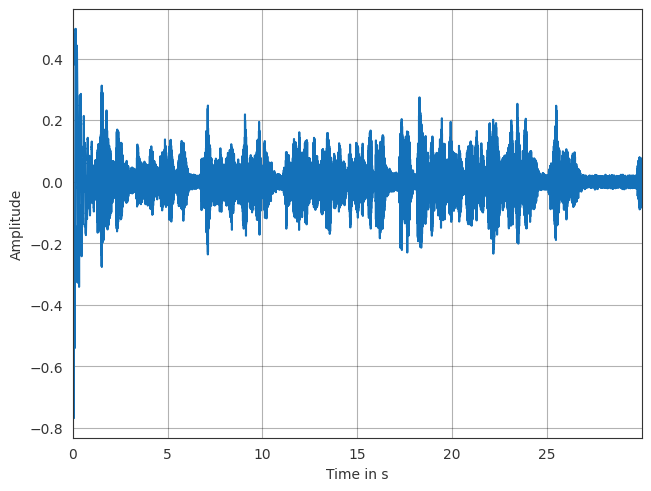

In [123]:
pf.plot.time(sig[5])
plt.show()